## Import

In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
from scipy.stats import pearsonr

In [3]:
import time
import math

In [4]:
import folium

## Defining Nodes

In [5]:
class City:
    
    """
    The City class represents a city with its x and y coordinates (usually longitude and latitude) and a name.

    Attributes:
    - x (float): The x-coordinate of the city (usually latitude).
    - y (float): The y-coordinate of the city (usually longitude).
    - name (str): The name of the city.
    """
    
    def __init__(self, x, y, name):
        
        """
        Constructor for the City class.

        Args:
        - x (float): The x-coordinate of the city.
        - y (float): The y-coordinate of the city.
        - name (str): The name of the city.

        Returns:
        - An instance of the City class.
        """
        
        self.x = x
        self.y = y
        self.name = name

## Defining Cost Functions

In [6]:
class anealor_model():
    
    """
    Implementation of a simulated annealing model to find geometric median
    among a set of cities.

    Attributes:
    - iterations (int): Number of iterations for the annealing process.
    - alpha (float): Cooling rate for the annealing process.
    - early_stopping_rounds (int): Number of rounds without improvement before stopping.
    """
    
    def __init__(self, iterations, alpha=0.99, early_stopping_rounds=100):
        
        """
        Constructor for the anealor_model class.
        
        Args:
        - iterations (int): Number of iterations.
        - alpha (float): Cooling rate. Default is 0.99.
        - early_stopping_rounds (int): Rounds without improvement before stopping. Default is 100.
        """
        
        self.iterations = iterations
        self.alpha = alpha
        self.early_stopping_rounds = early_stopping_rounds
    
    def haversine(self, coord1, coord2):
        
        """
        Calculate the Haversine distance between two coordinates.

        Args:
        - coord1 (City): First city.
        - coord2 (City): Second city.

        Returns:
        - distance (float): Distance in kilometers between the two cities.
        """
        
        R = 6371.0

        lon1 = math.radians(coord1.x)
        lat1 = math.radians(coord1.y)
        lon2 = math.radians(coord2.x)
        lat2 = math.radians(coord2.y)

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        a = max(0, a)
        a = min(1, a)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = R * c
        return distance
    
    def cost(self, city, cities):
        
        """
        Calculate the cumulative distance from a given point to a list of cities.

        Args:
        - city (City): Reference point.
        - cities (list of City): List of cities.

        Returns:
        - total cost (float): Cumulative distance.
        """
        
        costs = []
        lst = [city.x, city.y]
        
        for i in range(len(cities)):
            
            lst[0], lst[1] = self.fixer(lst[0], lst[1])
            costs.append(self.haversine(City(lst[0], lst[1], "x"), cities[i]))

        return(sum(costs))
        
    def fixer(self, x, y):
    
        """
        Adjust the coordinates to be within valid bounds.

        Args:
        - x (float): x-coordinate (usually longitude).
        - y (float): y-coordinate (usually latitude).

        Returns:
        - tuple: Adjusted (x, y) coordinates.
        """

    
        if (x < -180):

                x = x + 360

        if (x > 180):

            x = x - 360

        if (y < -90):

                y = y + 180

        if (y > 90):

            y = y - 180

        return x, y
    
    def err_pc(self, point, actual, cities):
        
        """
        Calculate the percentage error between observed and expected cost.

        Args:
        - point (City): Observed city.
        - actual (City): Expected city.
        - cities (list of City): List of cities.

        Returns:
        - percentage error (float).
        """
        
        observed = self.cost(point, cities)
        expected = self.cost(actual, cities)
        
        if expected == 0:
            return 0
        
        percentage_error = abs(observed - expected) / expected * 100
        return percentage_error
    
    def anealor(self, cities):
        
        """
        Implement the simulated annealing algorithm to find an optimal solution 
        among a set of cities.

        Args:
        - cities (list of City): List of cities.

        Returns:
        - tuple: Candidate solution, results, guess results, and step sizes.
        """
        
        results = []
        guess_results = []
        step_Size = []
        
        cand = [0, 0, 0]
        initial_step_size = 20
        temp = self.iterations
        
        # Initialize a candidate solution with random coordinates and its cost
        
        cand[0] = rd.randint(-180, 180)
        cand[1] = rd.randint(-90, 90)
        cand[2] = self.cost(City(cand[0], cand[1], "x"), cities)

        no_improvement_rounds = 0
        best_cost = float('inf')

        for i in range(self.iterations):
            
            # Create a potential new solution by perturbing the current candidate's coordinates
            # The magnitude of the perturbation decreases as the temperature drops.
            
            pot = [0, 0, 0]
            current_step_size = initial_step_size * (temp / self.iterations)
            pot[0] = cand[0] + (rd.uniform(-current_step_size, current_step_size) * temp / 10)
            pot[1] = cand[1] + (rd.uniform(-current_step_size, current_step_size) * temp / 10)
            
            # Ensure the potential solution's coordinates are valid
            
            pot[0], pot[1] = self.fixer(pot[0], pot[1])
            
            # Calculate the cost for the potential solution
            
            pot[2] = self.cost(City(pot[0], pot[1], x), cities)
            
            # Accept the potential solution if it's better, or with a certain probability if it's worse
            # This probabilistic acceptance allows for exploration and prevents being stuck in local minima
            
            if pot[2] < cand[2] or rd.random() < math.exp(-(pot[2] - cand[2]) / temp):
                cand = pot
                
            # Track the best cost found so far and check for early stopping
            
            if cand[2] < best_cost:
                best_cost = cand[2]
                no_improvement_rounds = 0
            else:
                no_improvement_rounds += 1
                if no_improvement_rounds >= self.early_stopping_rounds:
                    break
                    
            # Reduce the temperature by a factor of alpha
            
            temp = self.alpha * temp
            
            results.append(i)
            guess_results.append(cand[2])
            step_Size.append(current_step_size * temp / 100)

        cand[0], cand[1] = self.fixer(cand[0], cand[1])
        return cand, results, guess_results, step_Size

## Test

In [19]:
cities = [
    
    City(-122.4194, 37.7749, "SF"),
    City(121.5654, 25.0330, "TP"),
    City(126.9918, 37.5519, "SL"),
    City(73.7537, 33.1480, "MP"),
    
]

In [20]:
actual = [126.9918, 37.5519]

In [21]:
x = []
y = []

z = anealor_model(1500)

for i in range(200):
    
    k = z.anealor(cities)
    x.append(k[0][0])
    y.append(k[0][1])

print(np.median(x), np.median(y))

124.99348377463899 37.449243259997886


## Output

In [829]:
itr = [1, 5, 10, 15, 25, 50, 100, 500]

In [22]:
p = 5000

In [23]:
a = anealor_model(p, early_stopping_rounds = p)

In [24]:
x = []
y = []
i_s = []
mean_cost = []
step_Size = []

for i in range(1000):
    k = a.anealor(cities)
    x.append(k[0][0])
    y.append(k[0][1])
    i_s.append(k[1])
    mean_cost.append(k[2])
    step_Size.append(k[3])

In [25]:
averages_cost = []

for i in range(p):
    total = 0
    for j in range(1000):
        total += mean_cost[j][i]
    averages_cost.append(total / 1000)

In [26]:
averages_step_size = []

for i in range(p):
    total = sum(step_Size[j][i] for j in range(1000))
    averages_step_size.append(total / 1000)

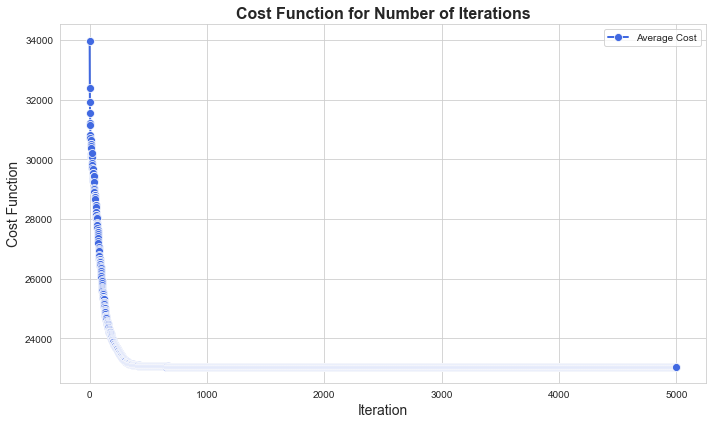

In [27]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x=i_s[0], y=averages_cost, ax=ax, lw=2, marker="o", markersize=8, label='Average Cost', color='royalblue')

ax.set_title('Cost Function for Number of Iterations', fontsize=16, fontweight='bold')
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Cost Function', fontsize=14)

plt.tight_layout()
plt.show()

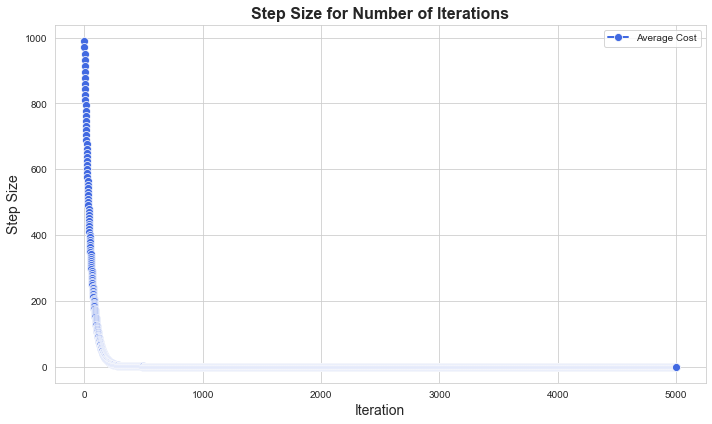

In [28]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x=i_s[0], y=averages_step_size, ax=ax, lw=2, marker="o", markersize=8, label='Average Cost', color='royalblue')

ax.set_title('Step Size for Number of Iterations', fontsize=16, fontweight='bold')
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Step Size', fontsize=14)

plt.tight_layout()
plt.show()

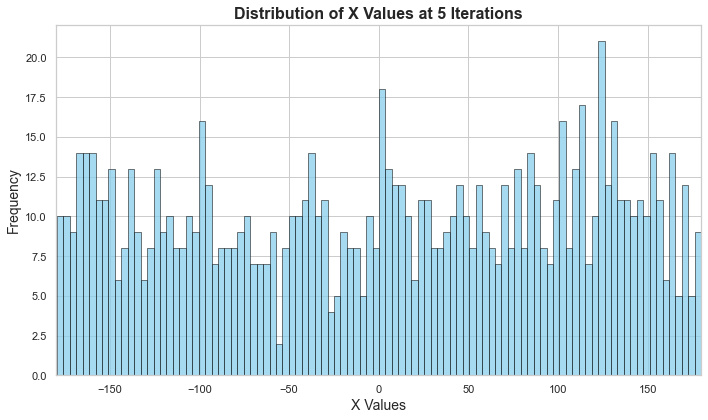

In [835]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(x, bins=100, ax=ax, kde=False, color='skyblue', edgecolor='black')

ax.set_xlim([-180, 180])
ax.set_title(f'Distribution of X Values at {p} Iterations', fontsize=16, fontweight='bold')
ax.set_xlabel('X Values', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

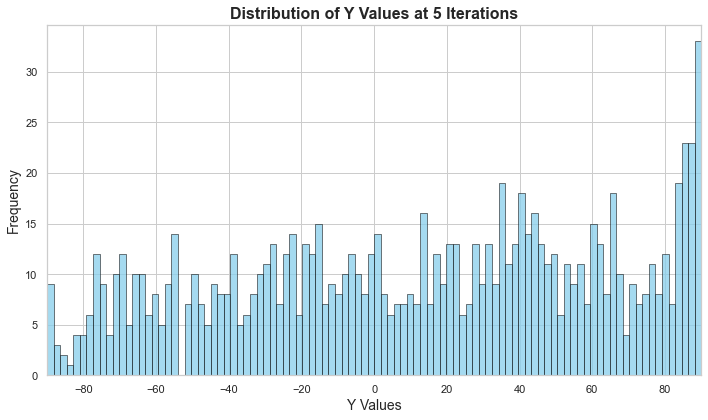

In [836]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(y, bins=100, ax=ax, kde=False, color='skyblue', edgecolor='black')

ax.set_xlim([-90, 90])
ax.set_title(f'Distribution of Y Values at {p} Iterations', fontsize=16, fontweight='bold')
ax.set_xlabel('Y Values', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

## Coordinates

In [49]:
itr = [1, 5, 10, 15, 25, 50, 100, 200, 500]

In [50]:
cities = [
    
    City(-122.4194, 37.7749, "SF"),
    City(121.5654, 25.0330, "TP"),
    City(126.9918, 37.5519, "SL"),
    City(73.7537, 33.1480, "MP"),
    
]

In [51]:
actual = [126.9918, 37.5519]

In [52]:
x_list = []
y_list = []

for i in itr:
    
    a = anealor_model(i)
    
    l, _, _, _ = a.anealor(cities)
    
    x_list.append(l[0])
    y_list.append(l[1])

In [53]:
print(x_list)

[-45, 159.75389587223023, -4.872731966921662, 141.0285179972108, 123.9690403632911, 123.45968917375787, 121.84874493412569, 126.24827966705163, 127.03089317383495]


In [54]:
print(y_list)

[52, 12.404345712275116, 88.06076502557328, 22.933337901567306, 40.98578912077445, 28.20647827898135, 34.498289887577336, 38.17863632379487, 37.59114847122674]


In [71]:
points = {
    "green": [(37.5519, 126.9918)],
    "red": [(y_list[8], x_list[8])]
}

In [73]:
m = folium.Map()

for color, coords in points.items():
    for coord in coords:
        folium.CircleMarker(
            location=coord,
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
        ).add_to(m)

m

## Accuracy by Balls

In [328]:
z = anealor_model(1500)

In [329]:
cities = [
    
    City(-122.4194, 37.7749, "SF"),
    City(121.5654, 25.0330, "TP"),
    City(106.8456, -6.2088, "JK"),
    City(73.0479, 33.6844, "IS"),
]

In [330]:
exact_ans = [103.574123, 39.030655]
place = City(exact_ans[0], exact_ans[1], "x")

In [331]:
balls = [1, 2, 3, 4, 5, 8, 10, 15, 25, 50, 100, 200]
avg_err = []
std_err = []

In [332]:
for ball in balls:
    
    errs = []
    
    for i in range(50):

        x = []
        y = []

        for i in range(ball):

            k, _, _, _ = z.anealor(cities)
            x.append(k[0])
            y.append(k[1])
        
        avg_x = np.median(x)
        avg_y = np.median(y)
        
        errs.append(z.err_pc(City(avg_x, avg_y, "0"), place, cities))
        
    avg_err.append(np.mean(errs))
    std_err.append(np.std(errs))
    print("✅")

✅
✅
✅
✅
✅
✅
✅
✅
✅
✅
✅
✅


In [333]:
print(avg_err)

[32.968865244471544, 91.26871637161852, 24.620577894888665, 73.24082667978176, 20.922609603407455, 53.51930491062318, 38.297201373185565, 8.140405711247077, 7.1021866420155835, 5.167052917697049, 2.4104394151702087, 2.0936701374802684]


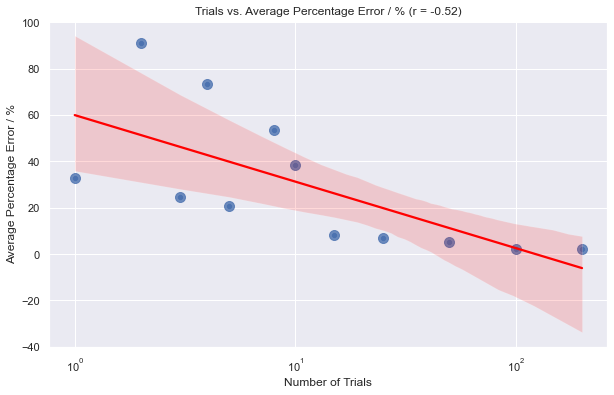

In [335]:
corr_coeff, _ = pearsonr(balls, avg_err)

sns.set_theme()
plt.figure(figsize=(10, 6))

ax = sns.scatterplot(x=balls, y=avg_err)
sns.regplot(x=balls, y=avg_err, logx=True, scatter_kws={'s':100}, line_kws={'color':'red'})

ax.set_xscale('log')
plt.title(f'Trials vs. Average Percentage Error / % (r = {corr_coeff:.2f})')
plt.xlabel("Number of Trials")
plt.ylabel("Average Percentage Error / %")

plt.show()

## Error by cities

cities = []

for i in range(20):
    
    cities.append(City(rd.randint(-180, 180), rd.randint(-90, 90), f"{i}"))

In [383]:
z = anealor_model(1500)

In [384]:
cities = [

    City(107, 25, "o"),
    City(69, -74, "o"),
    City(87, 32, "o"),
    City(165, 75, "o"),
    City(168, 64, "o"),
    
    City(114, -18, "o"),
    City(15, 34, "o"),
    City(59, 80, "o"),
    City(-26, -69, "o"),
    City(-3, -73, "o"),
    
    City(151, -48, "o"),
    City(-29, 89, "o"),
    City(-180, -28, "o"),
    City(-53, -29, "o"),
    City(-32, -47, "o"),
    
    City(177, -86, "o"),
    City(-163, 57, "o"),
    City(-5, -65, "o"),
    City(-173, 67, "o"),
    City(108, -73, "o"),
    
]

In [385]:
for city in cities:
    
    print(city.y, city.x, city.name)

25 107 o
-74 69 o
32 87 o
75 165 o
64 168 o
-18 114 o
34 15 o
80 59 o
-69 -26 o
-73 -3 o
-48 151 o
89 -29 o
-28 -180 o
-29 -53 o
-47 -32 o
-86 177 o
57 -163 o
-65 -5 o
67 -173 o
-73 108 o


In [386]:
cor_anw = [
    [107, 25],
    [98.410772, -25.36333],
    [101.200452, 23.043034],
    [107, 25],
    [104.118496, 31.708478],
    [107, 25],
    [97.144249, 30.854054],
    [93.959408, 36.51733],
    [87, 32],
    [87, 32],
    [99.465664, 20.591755],
    [95.424597, 27.731896],
    [107, 25],
    [98.762677, 21.647639],
    [114, -18],
    [111.779721, -19.646877],
    [114, -18],
    [113.233078, -18.832778],
    [114, -18],
    [113.999999, -18.000002]
]

In [387]:
err_list = []

In [388]:
for i in range(20):
    
    x_list = []
    y_list = []
    
    for j in range(1000):
        
        l, _, _, _ = z.anealor(cities[:i+1])
        x_list.append(l[0])
        y_list.append(l[1])
        
    fin_x = np.median(x_list)
    fin_y = np.median(y_list)
    
    err = z.err_pc(City(fin_x, fin_y, "a"), City(cor_anw[i][0], cor_anw[i][1], "b"), cities[:i+1])
    err_list.append(err)
    
    print("✅")
    print(fin_x)

✅
99.72462294484049
✅
-23.544221295616744
✅
73.1260325400902
✅
99.35961264781426
✅
103.88677858156578
✅
107.2383715604747
✅
92.89226778205617
✅
95.32972959351055
✅
88.61969395289142
✅
82.65721206926834
✅
72.66328996553904
✅
93.62896000955871
✅
105.91784425429191
✅
-51.70902356123761
✅
-42.473355216329
✅
-44.325158177096
✅
-72.87283157957708
✅
-48.48799542344082
✅
-62.054397340449384
✅
-45.6382685967115


In [389]:
print(err_list)

[0, 99.98515706902606, 19.24181843006292, 0.5979143966457462, 0.002817247986018468, 0.1091278997477132, 0.13655214141086622, 0.0348284539885429, 0.06588105069677685, 0.7370882493663249, 4.060914320356011, 0.020735372339822675, 0.04441207252635413, 34.509723321570185, 13.733776450370746, 8.930061142360216, 24.46301982334303, 6.513800044590994, 10.249300886419217, 7.99413897026702]


In [390]:
balls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

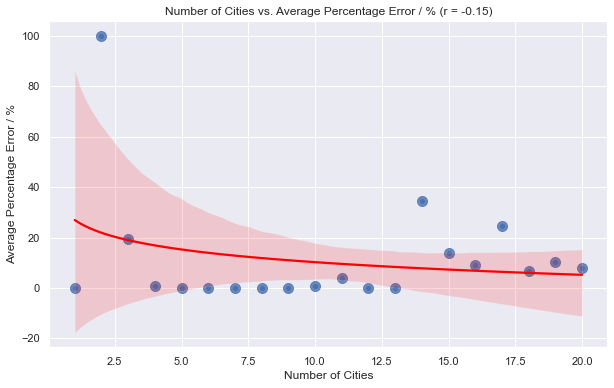

In [392]:
corr_coeff, _ = pearsonr(balls, err_list)

sns.set_theme()
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x=balls, y=err_list)
sns.regplot(x=balls, y=err_list, logx=True, scatter_kws={'s':100}, line_kws={'color':'red'})

plt.xlabel("Number of Cities")
plt.ylabel("Average Percentage Error / %")

plt.title(f'Number of Cities vs. Average Percentage Error / % (r = {corr_coeff:.2f})')

plt.show()

## Scaling by cities

In [396]:
time_list = []
cities = []

In [397]:
for i in range(50):
    
    t_list = []
    for j in range(10):
        cities.append(City(rd.randint(-180, 180), rd.randint(-90, 90), "x"))
    
    for j in range(30):
        
        t = time.time()
        z.anealor(cities)
        del_t = time.time() - t
        
        t_list.append(del_t)
        
    time_list.append(np.mean(t_list))

In [398]:
i_list = []

for i in range(50):
    
    i_list.append(i*10)

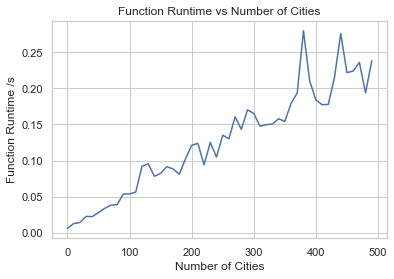

In [400]:
sns.set_style("whitegrid")
sns.lineplot(x=i_list, y=time_list)
plt.title("Function Runtime vs Number of Cities")
plt.xlabel("Number of Cities")
plt.ylabel("Function Runtime /s")
plt.show()

## Minerva HQ

In [401]:
z = anealor_model(1500)

In [402]:
cities = [

    City(-122.4194, 37.7749, "o"),
    City(126.9780, 37.5665, "o"),
    City(78.4867, 17.3850, "o"),
    
    City(13.4050, 52.5200, "o"),
    City(-58.3816, -34.6037, "o"),
    City(-0.1278, 51.5074, "o"),
    
    City(121.5654, 25.0330, "o"),
    
]

In [403]:
x_list = []
y_list = []

for i in range(1000):
    
    k = z.anealor(cities)
    x_list.append(k[0][0])
    y_list.append(k[0][1])
    
print(np.median(x_list))
print(np.median(y_list))

17.477076427822578
56.89853269434947


In [404]:
cy = []
cx = []

for city in cities:
    
    cy.append(city.y)
    cx.append(city.x)

In [405]:
points = {
    "green": [(54.615139, 14.429669)],
    "red": [(np.median(y_list), np.median(x_list))]
}

points['black'] = list(zip(cy, cx))

In [406]:
m = folium.Map()

for color, coords in points.items():
    for coord in coords:
        folium.CircleMarker(
            location=coord,
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
        ).add_to(m)

m